In [1]:
import deephyper_benchmark as dhb


dhb.load("DTLZ")
from deephyper_benchmark.lib.dtlz import hpo, metrics

In [2]:
from deephyper.search.hps import CBO
from deephyper.search.hps._mpi_doptuna import MPIDistributedOptuna

In [3]:
hpo.problem

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

In [4]:
num_rep = 10
max_evals = 1_000

## Random Search (With DeepHyper)

In [5]:
results_random = []
for i in range(num_rep):
    print(i)
    # res = CBO(hpo.problem, hpo.run, surrogate_model="DUMMY").search(max_evals=max_evals)
    res = MPIDistributedOptuna(hpo.problem, hpo.run, sampler="DUMMY", n_objectives=2).search(max_evals=max_evals)
    results_random.append(res)

0


/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:126: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


1
2
3
4
5
6
7
8
9


In [6]:
pe = metrics.PerformanceEvaluator()

hv_array_random = []
for res in results_random:
    sol = res[["objective_0", "objective_1"]].values
    hv = []
    for i in range(len(sol)):
        hv.append(pe.hypervolume(sol[:i+1]))
    hv_array_random.append(hv)

## DeepHyper Sequential

In [ ]:
from deephyper.search.hps import CBO


results_baseline = []
for i in range(num_rep):
    print(i)
    res = CBO(hpo.problem, hpo.run, objective_scaler="minmaxlog", update_prior=True, update_prior_quantile=0.25).search(max_evals=max_evals)
    results_baseline.append(res)

0
1


In [ ]:
pe = metrics.PerformanceEvaluator()

hv_array_deephyper = []
for res in results_baseline:
    sol = res[["objective_0", "objective_1"]].values
    hv = []
    for i in range(len(sol)):
        hv.append(pe.hypervolume(sol[:i+1]))
    hv_array_deephyper.append(hv)

## Optuna (NSGAII)

In [7]:
from deephyper.search.hps._mpi_doptuna import MPIDistributedOptuna


results_nsgaii = []
for i in range(num_rep):
    print(i)
    res = MPIDistributedOptu na(hpo.problem, hpo.run, sampler="NSGAII", n_objectives=2).search(max_evals=max_evals)
    results_nsgaii.append(res)

0
1
2
3
4
5
6
7
8
9


In [8]:
pe = metrics.PerformanceEvaluator()

hv_array_nsgaii = []
for res in results_nsgaii:
    sol = res[["objective_0", "objective_1"]].values
    hv = []
    for i in range(len(sol)):
        hv.append(pe.hypervolume(sol[:i+1]))
    hv_array_nsgaii.append(hv)

## Optuna (TPE)

In [9]:
results_motpe = []
for i in range(num_rep):
    print(i)
    res = MPIDistributedOptuna(hpo.problem, hpo.run, sampler="TPE", n_objectives=2).search(max_evals=max_evals)
    results_motpe.append(res)

0
1
2
3
4
5
6
7
8
9


In [10]:
pe = metrics.PerformanceEvaluator()

hv_array_tpe = []
for res in results_motpe:
    sol = res[["objective_0", "objective_1"]].values
    hv = []
    for i in range(len(sol)):
        hv.append(pe.hypervolume(sol[:i+1]))
    hv_array_tpe.append(hv)

## Figures

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    
    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width, height = set_size(252, fraction=1.0)
print(f"{width=}, {height=}")

font = 9

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    'font.size': font,
    'figure.figsize': (width, height), 
    'figure.facecolor': 'white', 
    'savefig.dpi': 300, 
    'figure.subplot.bottom': 0.125, 
    'figure.edgecolor': 'white',
    'xtick.labelsize': font,
    'ytick.labelsize': font,
    'legend.fontsize': font,
})

width=3.4869240348692405, height=2.1550375697381146


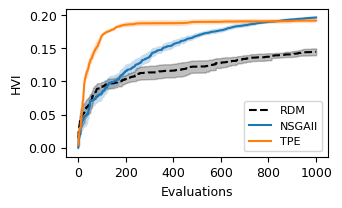

In [14]:
x = np.arange(max_evals)+1
kappa = 1.96

plt.figure()

# random
y_mean = np.mean(hv_array_random, axis=0)
y_stde = np.std(hv_array_random, axis=0)/np.sqrt(num_rep)
plt.plot(x, y_mean, color="black", linestyle="--", label="RDM")
plt.fill_between(x, y_mean - kappa*y_stde, y_mean + kappa * y_stde, color="black", alpha=0.25)

# y_mean = np.mean(hv_array_deephyper, axis=0)
# y_stde = np.std(hv_array_deephyper, axis=0)/np.sqrt(num_rep)
# plt.plot(x, y_mean, label="DH")
# plt.fill_between(x, y_mean - kappa*y_stde, y_mean + kappa * y_stde, alpha=0.25)

y_mean = np.mean(hv_array_nsgaii, axis=0)
y_stde = np.std(hv_array_nsgaii, axis=0)/np.sqrt(num_rep)
plt.plot(x, y_mean, label="NSGAII")
plt.fill_between(x, y_mean - kappa*y_stde, y_mean + kappa * y_stde, alpha=0.25)

y_mean = np.mean(hv_array_tpe, axis=0)
y_stde = np.std(hv_array_tpe, axis=0)/np.sqrt(num_rep)
plt.plot(x, y_mean, label="TPE")
plt.fill_between(x, y_mean - kappa*y_stde, y_mean + kappa * y_stde, alpha=0.25)


# y_mean = np.mean(hv_array_cmaes, axis=0)
# y_stde = np.std(hv_array_cmaes, axis=0)/np.sqrt(num_rep)
# plt.plot(x, y_mean, label="CMAES")
# plt.fill_between(x, y_mean - kappa*y_stde, y_mean + kappa * y_stde, alpha=0.25)

# plt.yscale("log")
plt.ylabel("HVI")
plt.xlabel("Evaluations")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("dtlzii_deephyper_vs_optuna.png")
plt.show()